# Finding symmetries - Mexican hat

In [1]:
import numpy as np
#import torch
#import torch.nn as nn
import numpy as np
#import torch.optim as optim
#import torch.nn.functional as F
#from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow

/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/.virtualenvs/python3_ml/lib/python3

1. Defining the potential. 

The paper doesn't tell us what they used as input to the DNN, but I'm assuming it's the coordinates (x, y) and they use the network to find the underlying potential. 

I think giving it the potential to classify the potential is too easy so (x, y) made more sense to me.  

In [2]:
#def v(r):
#    return -2.3 * r**2 + r**4

def v(x, y):
    a = 2.3
    r2 = (x**2 + y**2) 
    return -a*r2 + r2**2

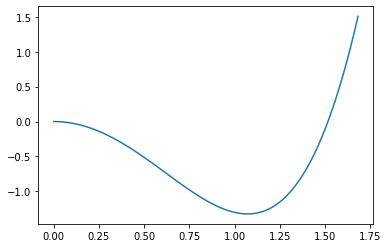

In [3]:
# quick plot of the potential 
x_test = np.arange(0.,1.2,0.01)
r_test = np.sqrt(x_test**2 + x_test**2)
v_test = v(x_test, x_test)
plt.plot(r_test, v_test)
plt.show()

2. Generate the samples. 

I made this in a way that involved less looping.
Also, I wanted the points to be more separated, like in the paper, to have the final clusters more defined. 

To get samples that are "continuous" along the potential, remove v_stricter_bounds.

In [4]:
v_lower_bounds = np.array([i/5 - 10e-3 for i in range(-5, 6)])  # real bounds
v_stricter_bounds = np.array([i/5 - 10e-4 for i in range(-5, 6)])  # stricter bounds
bins = np.sort(np.concatenate((v_lower_bounds, v_stricter_bounds)))

In [5]:
np.random.seed(123)

n = 20000000  
x1 = np.random.uniform(0, 1.2, n)  
x2 = np.random.uniform(0, 1.2, n)
V_rand = v(x1, x2)

bin_labels = np.digitize(V_rand, bins=bins, right=False)

In [6]:
# keep only the content of the odd bins 
nsamples_class = 1000
nclasses = 11
X = np.zeros((nsamples_class*nclasses, 2))
Y = np.zeros((nsamples_class*nclasses), dtype=int)
for i in range(11):
    class_ix = np.where(bin_labels==(i*2+1))[0][:nsamples_class]
    X[i*nsamples_class : (i+1)*nsamples_class, 0] = x1[class_ix]
    X[i*nsamples_class : (i+1)*nsamples_class, 1] = x2[class_ix]
    Y[i*nsamples_class : (i+1)*nsamples_class] = (bin_labels[class_ix]-1)/2

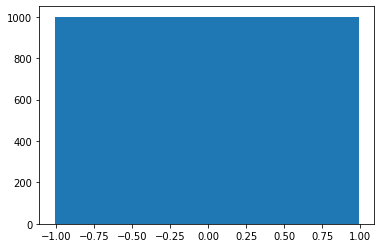

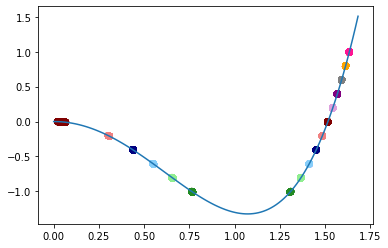

In [7]:
# quick check that the dataset is balanced...
plt.hist(v(X[:, 0], X[:, 1]), v_lower_bounds)
plt.show()

# and that the points are uniform along the potential
colors = ['forestgreen', 'lightgreen', 'lightskyblue', 'navy',
          'lightcoral', 'maroon', 'plum', 'purple', 'gray',
          'orange', 'deeppink']
r = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
c_samples = [colors[i] for i in Y]
plt.scatter(r, v(X[:, 0], X[:, 1]), c=c_samples)  
plt.plot(r_test, v_test)
plt.show()

In [8]:
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

In [9]:
Y = to_categorical(Y, num_classes=11)

3. Train

The paper says they stopped at 95% accuracy but I'm just gonna wing it. 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
import tensorflow.keras.backend as K 
from tensorflow.keras.optimizers import Adam

In [11]:
model = Sequential()
model.add(Dense(80, 'relu', input_dim=2))
model.add(Dense(80, 'relu'))
model.add(Dense(80, 'relu'))
model.add(Dense(80, 'relu'))
model.add(Dense(80, 'relu'))
model.add(Dense(80, 'relu'))
model.add(Dense(80, 'relu'))
model.add(Dense(11, 'softmax'))
opt = Adam(lr=0.0001)
model.compile(opt, 'categorical_crossentropy', metrics=['acc'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
____

In [12]:
model.fit(X, Y, 
          batch_size=28, epochs=12)

Epoch 1/12
11000/11000 [==============================] - 1s 111us/sample - loss: 2.1114 - acc: 0.2403
Epoch 2/12
11000/11000 [==============================] - 2s 185us/sample - loss: 1.3468 - acc: 0.5050
Epoch 3/12
11000/11000 [==============================] - 2s 185us/sample - loss: 1.0003 - acc: 0.6529
Epoch 4/12
11000/11000 [==============================] - 2s 196us/sample - loss: 0.7424 - acc: 0.7449
Epoch 5/12
11000/11000 [==============================] - 2s 174us/sample - loss: 0.5773 - acc: 0.8259
Epoch 6/12
11000/11000 [==============================] - 1s 117us/sample - loss: 0.4450 - acc: 0.9233
Epoch 7/12
11000/11000 [==============================] - 2s 145us/sample - loss: 0.3285 - acc: 0.9620
Epoch 8/12
11000/11000 [==============================] - 2s 146us/sample - loss: 0.2394 - acc: 0.9739
Epoch 9/12
11000/11000 [==============================] - 2s 176us/sample - loss: 0.1748 - acc: 0.9825
Epoch 10/12
11000/11000 [==============================] - 1s 128us/sampl

In [13]:
embed_layer=-2
embed_func = K.function([model.layers[0].input], [model.layers[-2].output])
embed_tensor = embed_func(X)[0]

In [14]:
from sklearn.manifold import TSNE

In [15]:
xy_embed = TSNE(n_components=2, init='random', 
                random_state=123, perplexity=50)

embedding = xy_embed.fit_transform(embed_tensor)

In [16]:
train_colors = [colors[int(i)] for i in np.argmax(Y, axis=1)]

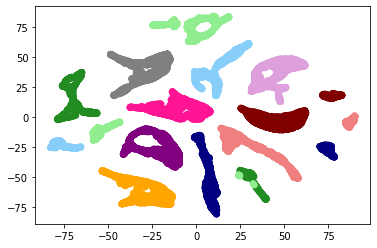

In [17]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=train_colors)

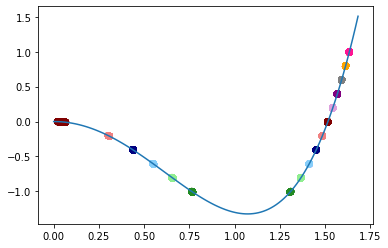

In [18]:
# plotting again for reference
plt.scatter(r, v(X[:, 0], X[:, 1]), c=c_samples)  
plt.plot(r_test, v_test)
plt.show()